## New York city accident data analysis

For this data analysis we are using Kaggle data set **Vehicle Collisions in NYC, Jan 2015 - Feb 2018**. It has 29 columns.

- UNIQUE KEY
- DATE
- TIME
- BOROUGH
- ZIP CODE
- LATITUDE
- LONGITUDE
- LOCATION
- ON STREET NAME
- CROSS STREET NAME
- OFF STREET NAME
- PERSONS INJURED
- PERSONS KILLED
- PEDESTRIANS INJURED
- PEDESTRIANS KILLED
- CYCLISTS INJURED
- CYCLISTS KILLED
- MOTORISTS INJURED
- MOTORISTS KILLED
- VEHICLE 1 TYPE
- VEHICLE 2 TYPE
- VEHICLE 3 TYPE
- VEHICLE 4 TYPE
- VEHICLE 5 TYPE
- VEHICLE 1 FACTOR
- VEHICLE 2 FACTOR
- VEHICLE 3 FACTOR
- VEHICLE 4 FACTOR
- VEHICLE 5 FACTOR

I had imported the CSV file to Mongo DB using the **Mongo Compass** tool. Here is an example of the document 
```
{
    "_id": "643e11185527f957095848b1",
    "UNIQUE KEY": "3146493",
    "DATE": "01/01/2015",
    "TIME": "11:30",
    "BOROUGH": "QUEENS",
    "ZIP CODE": 11101,
    "LATITUDE": 40.7460347,
    "LONGITUDE": -73.9344002,
    "LOCATION": "(40.7460347, -73.9344002)",
    "ON STREET NAME": "QUEENS BOULEVARD",
    "CROSS STREET NAME": "SKILLMAN AVENUE",
    "PERSONS INJURED": 0,
    "PERSONS KILLED": 0,
    "PEDESTRIANS INJURED": 0,
    "PEDESTRIANS KILLED": 0,
    "CYCLISTS INJURED": 0,
    "CYCLISTS KILLED": 0,
    "MOTORISTS INJURED": 0,
    "MOTORISTS KILLED": 0,
    "VEHICLE 1 TYPE": "PASSENGER VEHICLE",
    "VEHICLE 2 TYPE": "PASSENGER VEHICLE",
    "VEHICLE 1 FACTOR": "UNSPECIFIED",
    "VEHICLE 2 FACTOR": "UNSPECIFIED"
}
```

In [18]:
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime
from statistics import mean

In [19]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["db_no_sql_proj"]
mycol = mydb["weather1"]

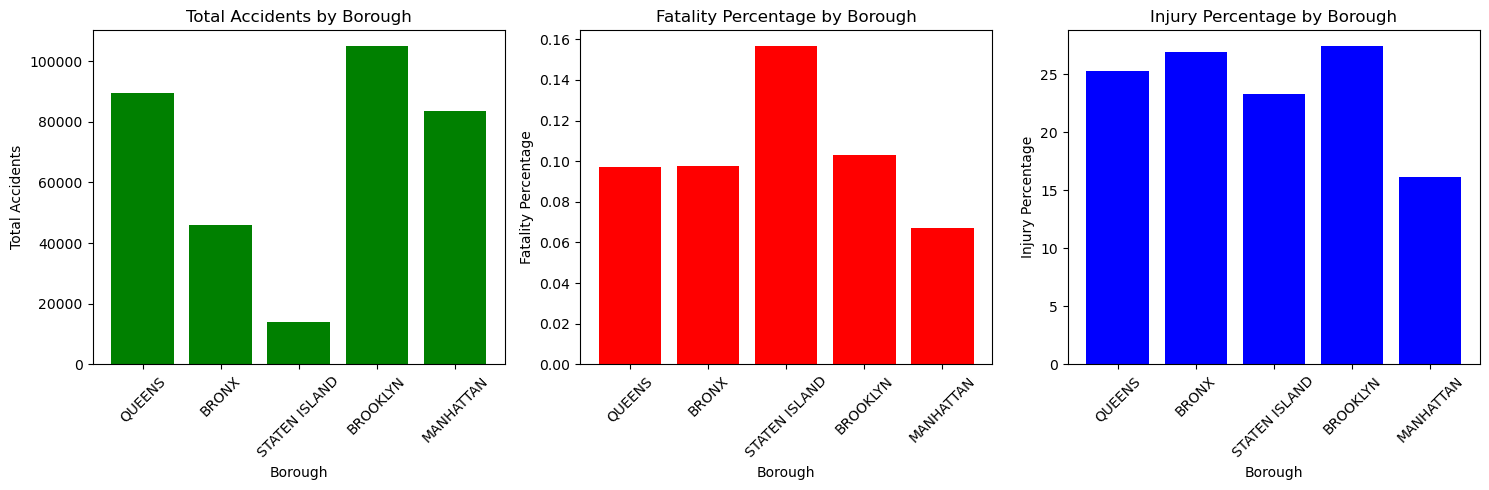

In [20]:
pipeline = [
    {
        "$match": {
            "BOROUGH": { "$exists": True, "$ne": None }
        }
    },
    {
        "$group": {
            "_id": "$BOROUGH",
            "totalAccidents": { "$sum": 1 },
            "totalInjuries": { "$sum": "$PERSONS INJURED" },
            "totalFatalities": { "$sum": "$PERSONS KILLED" }
            
        }
    },
    {
        "$project": {
            "_id": 0,
            "borough": "$_id",
            "totalFatalities": 1,
            "totalInjuries": 1,
            "totalAccidents": 1,
            "injury%": {"$multiply": [{"$divide": ["$totalInjuries", "$totalAccidents"]}, 100]},
            "fatality%": {"$multiply": [{"$divide": ["$totalFatalities", "$totalAccidents"]}, 100]}
        }
    }
    ]
    
    
result = mycol.aggregate(pipeline)

#for doc in result:
    #print(doc)


boroughs = []
injury_percentages = []
fatality_percentages = []
accidents = []

for doc in result:
    boroughs.append(doc['borough'])
    injury_percentages.append(doc['injury%'])
    fatality_percentages.append(doc['fatality%'])
    accidents.append(doc['totalAccidents'])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].bar(boroughs, accidents, color='g')
ax[0].set_title('Total Accidents by Borough')
ax[0].set_xlabel('Borough')
ax[0].set_ylabel('Total Accidents')
ax[0].tick_params(axis='x', rotation=45)

ax[1].bar(boroughs, fatality_percentages, color='r')
ax[1].set_title('Fatality Percentage by Borough')
ax[1].set_xlabel('Borough')
ax[1].set_ylabel('Fatality Percentage')
ax[1].tick_params(axis='x', rotation=45)

ax[2].bar(boroughs, injury_percentages, color='b')
ax[2].set_title('Injury Percentage by Borough')
ax[2].set_xlabel('Borough')
ax[2].set_ylabel('Injury Percentage')
ax[2].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

##### Analysis 1: Analyzing the accidents occurring in each borough of New York to ascertain whether they pose a risk of injury, fatality, or both.

- The data reveals that Brooklyn, Queens, Manhattan, and Queens exhibit high numbers of accidents, while the Staten Island records comparatively low accidents.

- When boroughs' mortality rates are compared, it becomes clear that Staten Island has the highest rate despite having fewer accidents. The fatality rates in the remaining boroughs, however, are comparable.

- Additionally, there are differences in the injury rate between the boroughs, with Manhattan having the lowest injury rate and the Bronx and Brooklyn having the highest rates.

Based on the analysis, it can be inferred that Manhattan poses the lowest risk of injury and fatality in the event of an accident in comparison to other boroughs of New York. Conversely, an accident in Staten Island carries a higher probability of injury and fatality.

So lets explore Staten Island fatalities.

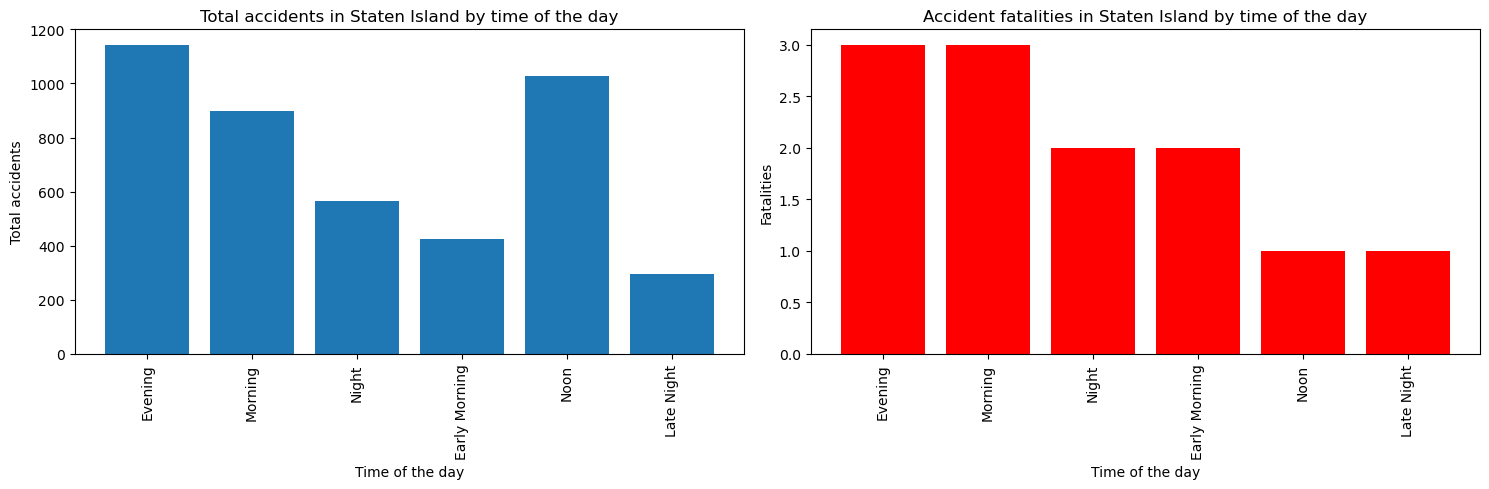

In [21]:
# Lets explore state island 

staten_island_pipeline = [
    {
        "$match": 
        {
            "BOROUGH": { "$exists": True, "$ne": None, "$eq": "STATEN ISLAND" }
        }
    },
    {
        "$group": {
            "_id": {'$toInt': {'$arrayElemAt': [{'$split': ["$TIME", ':']},0]}},
            "totalAccidents": { "$sum": 1 },
            "totalFatalities": { "$sum": "$PERSONS KILLED" }
        }
    },
    {
        "$project": {
            "_id": 0,
            "time": "$_id",
            "totalFatalities": 1,
            "totalAccidents": 1
        }
    },
    {
        "$project": {
            "_id": 0,
            "time": 1,
            "totalFatalities": 1,
            "totalAccidents": 1,
            "time_of_the_day": {
                "$switch": {
                    "branches": [
                        { 
                            "case": {
                                "$and": [
                                    { "$gte": ["$time", 0] },
                                    { "$lt": ["$time", 4] }
                                    ]
                            },
                            "then": "Late Night" 
                        },
                        { 
                            "case": {
                                "$and": [
                                    { "$gte": ["$time", 4] },
                                    { "$lt": ["$time", 8] }
                                    ]
                            },
                            "then": "Early Morning" 
                        },
                        { 
                            "case": {
                                "$and": [
                                    { "$gte": ["$time", 8] },
                                    { "$lt": ["$time", 12] }
                                    ]
                            },
                            "then": "Morning" 
                        },
                        { 
                            "case": {
                                "$and": [
                                    { "$gte": ["$time", 12] },
                                    { "$lt": ["$time", 16] }
                                    ]
                            },
                            "then": "Noon" 
                        },
                        { 
                            "case": {
                                "$and": [
                                    { "$gte": ["$time", 16] },
                                    { "$lt": ["$time", 20] }
                                    ]
                            },
                            "then": "Evening" 
                        },
                        { 
                            "case": { "$gte": ["$time", 20 ]}, 
                            "then": "Night"
                        }
                ],
                "default": "Invalid"
                }
            }
        }
    },

    {
        '$sort': {
            'totalFatalities': -1
        }
    }
]

staten_island_result = mycol.aggregate(staten_island_pipeline)

staten_island = []

for r in staten_island_result:
    #print(r)
    staten_island.append(r)
    

time_of_the_day = []
fatalities = []
total_accidents = []

for si in staten_island:
    time_of_the_day.append(si['time_of_the_day'])
    fatalities.append(si['totalFatalities'])
    total_accidents.append(si['totalAccidents'])
    
figure, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[1].bar(time_of_the_day, fatalities, color='r')
axs[1].set_title('Accident fatalities in Staten Island by time of the day')
axs[1].set_xlabel('Time of the day')
axs[1].set_ylabel('Fatalities')
axs[1].tick_params(axis='x', rotation=90)

axs[0].bar(time_of_the_day, total_accidents)
axs[0].set_title('Total accidents in Staten Island by time of the day')
axs[0].set_xlabel('Time of the day')
axs[0].set_ylabel('Total accidents')
axs[0].tick_params(axis='x', rotation=90)


plt.subplots_adjust(hspace=1, bottom=0.2)
plt.tight_layout()
plt.show()

##### Analysis 1.1
- The analysis reveals that the majority of accidents and fatalities occur during the morning and evening rush hour periods, between 8 am to 12 pm and 4 pm to 8 pm. This can be attributed to the higher volume of vehicles on the road during these times, as people commute to and from work. 

- Conversely, there are fewer accidents during the early morning and late night periods when there are fewer people on the road.

- However, the analysis also highlights a concerning trend of higher fatality rates during the early morning period, between 4 am to 8 am. This may be indicative of driver inattention or fatigue, which could be further investigated to improve road safety during these times.

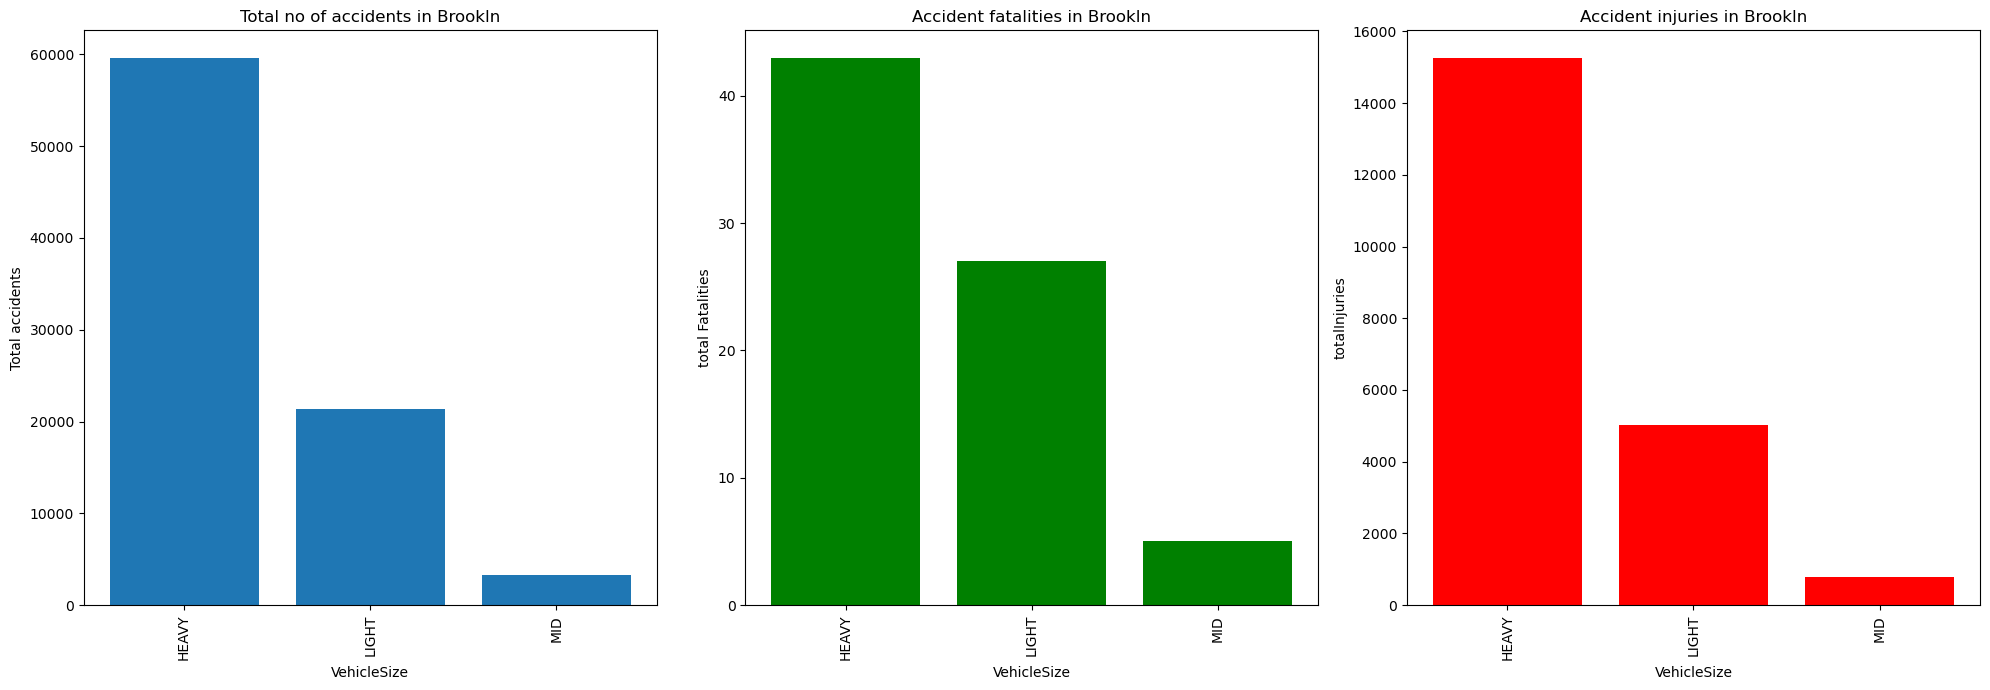

In [22]:
borough_vehicle_pipeline = [
    {
        "$match": {
            "$and": [
                {"BOROUGH": {"$exists": True, "$ne": None, "$eq": "QUEENS"}},
                {"VEHICLE 1 TYPE": {"$nin": [None, "Unspecified", "UNSPECIFIED", "UNKNOWN", "OTHER"]}},
                {"_id": {"$ne": "UNSPECIFIED"}}
            ]
        }
    },
    {
        "$addFields": {
            "VehicleSize": {
                "$switch": {
                    "branches": [
                        {"case": {"$in": ["$VEHICLE 1 TYPE", ["SPORT UTILITY/STATION WAGON"]]}, "then": "LIGHT"},
                        {"case": {"$eq": ["$VEHICLE 1 TYPE", "SCOOTER"]}, "then": "LIGHT"},
                        {"case": {"$eq": ["$VEHICLE 1 TYPE", "TAXI"]}, "then": "MID"},
                        {"case": {"$eq": ["$VEHICLE 1 TYPE", "VAN"]}, "then": "MID"},
                        {"case": {"$eq": ["$VEHICLE 1 TYPE", "SMALL COM VEH(4 TIRES)"]}, "then": "MID"},
                        {"case": {"$in": ["$VEHICLE 1 TYPE", ["LARGE COM VEH(6 OR MORE TIRES)", "PASSENGER VEHICLE", "PICK-UP TRUCK"]]}, "then": "HEAVY"},
                        {"case": {"$eq": ["$VEHICLE 1 TYPE", "OTHER"]}, "then": None}
                    ],
                    "default": None
                }
            }
        }
    },
    {
        "$match": {
            "VehicleSize": {"$ne": None}
        }
    },
    {
        "$group": {
            "_id": "$VehicleSize",
            "totalFatalities": {"$sum": "$PERSONS KILLED"},
            "totalInjuries": {"$sum": "$PERSONS INJURED"},
            "totalAccidents": {"$sum": 1}
        }
    },
    {
        "$project": {
            "_id": 0,
            "VehicleSize": "$_id",
            "totalInjuries": 1,
            "totalFatalities": 1,
            "totalAccidents": 1
        }
    },
    {
        "$sort": {
            "totalAccidents": -1,
            "totalInjuries": 1,
            "totalFatalities": 1
        }
    },
    {"$limit": 9}
]


most_injury_result = mycol.aggregate(borough_vehicle_pipeline)

    
brookln_data = []

for x in most_injury_result:
    brookln_data.append(x)
    

vehicle_type = []
injuries = []
fatalities = []
total_accidents = []

for hi in brookln_data:
    vehicle_type.append(hi['VehicleSize'])
    injuries.append(hi['totalInjuries'])
    fatalities.append(hi['totalFatalities'])
    total_accidents.append(hi['totalAccidents'])
    
# print(injuries)
# print(fatalities)
# print(total_accidents)



figure, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

axs[2].bar(vehicle_type, injuries, color='r')
axs[2].set_title('Accident injuries in Brookln')
axs[2].set_xlabel('VehicleSize')
axs[2].set_ylabel('totalInjuries')
axs[2].tick_params(axis='x', rotation=90)

axs[1].bar(vehicle_type, fatalities, color='g')
axs[1].set_title('Accident fatalities in Brookln')
axs[1].set_xlabel('VehicleSize')
axs[1].set_ylabel('total Fatalities')
axs[1].tick_params(axis='x', rotation=90)

axs[0].bar(vehicle_type, total_accidents)
axs[0].set_title('Total no of accidents in Brookln')
axs[0].set_xlabel('VehicleSize')
axs[0].set_ylabel('Total accidents')
axs[0].tick_params(axis='x', rotation=90)

plt.subplots_adjust(hspace=1, bottom=0.2)
plt.tight_layout()
plt.show()

##### Analysis 2.1
- The analysis reveals heavy are the vehicle types involved in the most number of accident,injuries and fatalities in Brooklyn, New York. 

- However, we can see that fatality rate is much higher than injury rate in light-type of vehicles. 

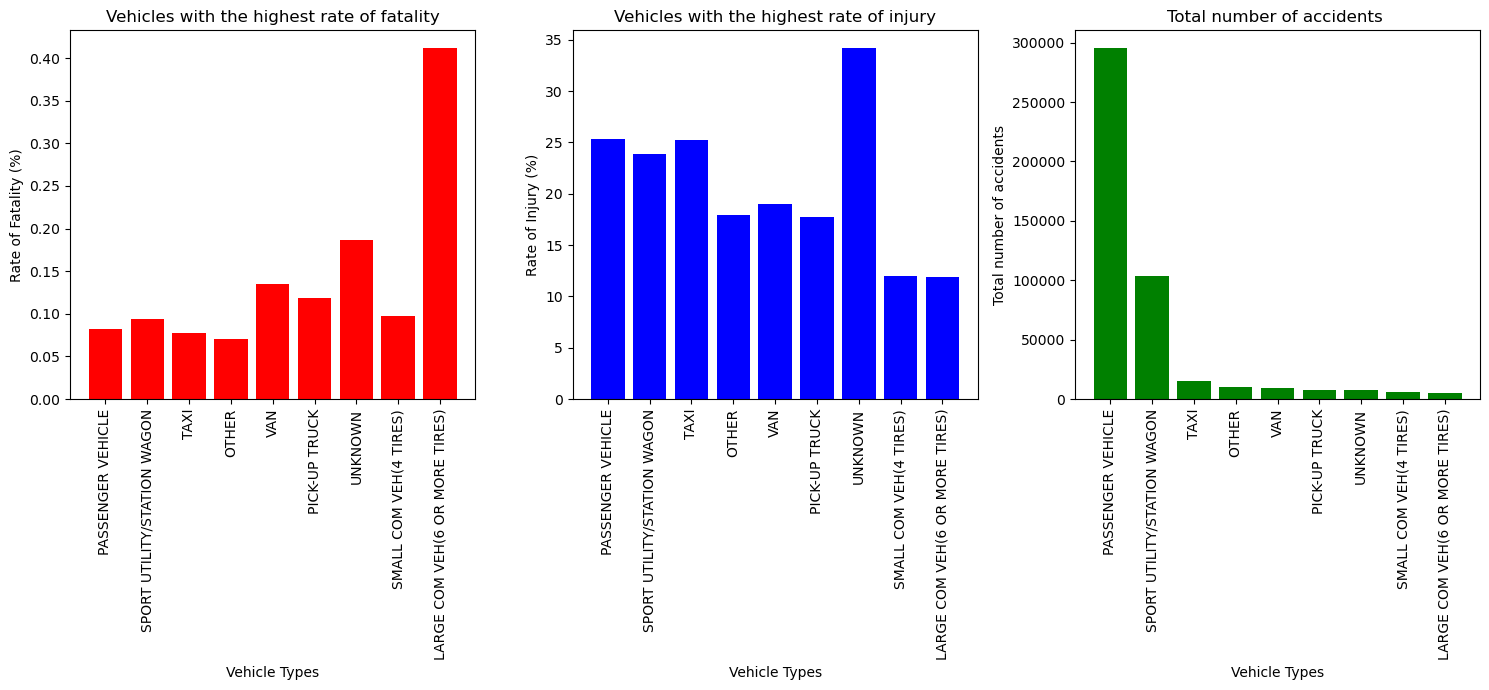

In [23]:
pipeline2 = [

        # Filter for accidents involving the top 10 vehicle types
        {
            "$match": {
                "$and": [
                    {"VEHICLE 1 TYPE": {"$nin":[None, "Unspecified", "UNSPECIFIED"]}},
                    {"_id": {"$ne": "UNSPECIFIED"}}
                ]
            }
        },

        # Group by vehicle type and calculate totals
        { "$group": {
            "_id": "$VEHICLE 1 TYPE",
            "persons_killed": { "$sum": "$PERSONS KILLED" },
            "persons_injured": { "$sum": "$PERSONS INJURED" },
            "total_accidents": { "$sum": 1 }
        }
        },

        #Rename fields and calculate injury and fatality percentages
        { "$project": {
            "vehicle_type": "$_id",
            "persons_killed": 1,
            "persons_injured": 1,
            "total_accidents": 1,
            "injury_percent": { "$round": [ { "$multiply": [ { "$divide": ["$persons_injured", "$total_accidents"] }, 100 ] }, 1 ] },
            "fatality_percent": { "$round": [ { "$multiply": [ { "$divide": ["$persons_killed", "$total_accidents"] }, 100 ] }, 3 ] }
        }
        },

        #Sort by total accidents in descending order
        { "$sort": { "total_accidents": -1 } },
        {"$limit": 9}]

# execute the aggregation pipeline and print the results
result3 = mycol.aggregate(pipeline2)

#for doc in result3:
    #pprint(doc)

vehicle_types = []
injury_percentages = []
fatality_percentages = []
accidents = []

for doc in result3:
    vehicle_types.append(doc['vehicle_type'])
    injury_percentages.append(doc['injury_percent'])
    fatality_percentages.append(doc['fatality_percent'])
    accidents.append(doc['total_accidents'])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

ax[0].bar(vehicle_types, fatality_percentages, color='r')
ax[0].set_title('Vehicles with the highest rate of fatality')
ax[0].set_xlabel('Vehicle Types')
ax[0].set_ylabel('Rate of Fatality (%)')
ax[0].tick_params(axis='x', rotation=90)

ax[1].bar(vehicle_types, injury_percentages, color='b')
ax[1].set_title('Vehicles with the highest rate of injury')
ax[1].set_xlabel('Vehicle Types')
ax[1].set_ylabel('Rate of Injury (%)')
ax[1].tick_params(axis='x', rotation=90)

ax[2].bar(vehicle_types, accidents, color='g')
ax[2].set_title('Total number of accidents ')
ax[2].set_xlabel('Vehicle Types')
ax[2].set_ylabel('Total number of accidents')
ax[2].tick_params(axis='x', rotation=90)

plt.subplots_adjust(hspace=1, bottom=0.2)
plt.tight_layout()
plt.show()

##### Analysis 2.2
- The analysis reveals Passenger Vehicles are the vehicle types involved in the most number of accident, followed by Sedands and SUVs/Station Wagons. 

- Bicycle and Motorcycle have an extreme rate of injury (>50%). Hence, it can be concluded that two wheelers are prone to injuries.

- Motorcycle, Bicycle, Bus, Large Commerical Vehicles have the highest rate of fatality. Hence, it can be concluded that vehicles of the extreme weights are more deadly overall.

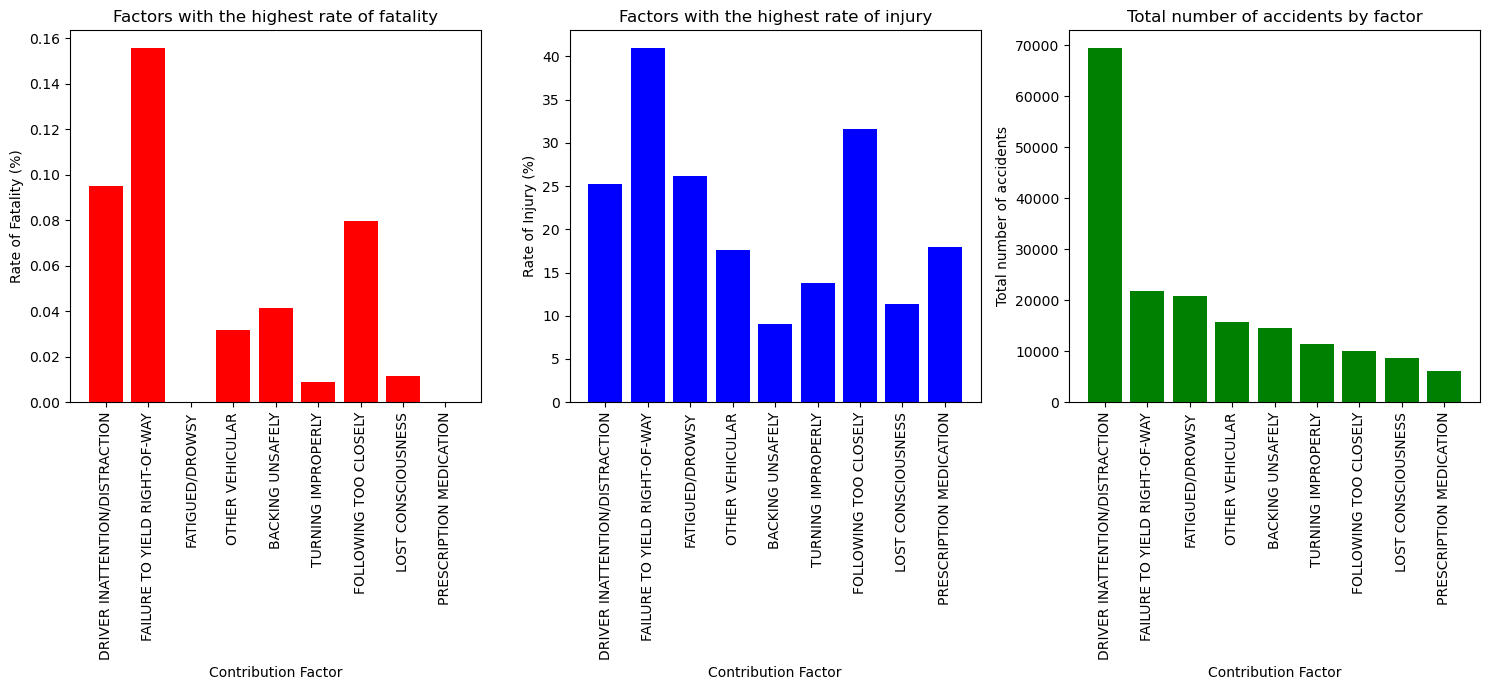

In [24]:
pipeline1 = [
    {
        "$match": {
            "$and": [
                    {"VEHICLE 1 FACTOR": {"$nin":[None, "Unspecified", "UNSPECIFIED"]}},
                    #{"VEHICLE 1 FACTOR": {"$ne":[None, "UNSPECIFIED"]}},
                    {"_id": {"$ne": "UNSPECIFIED"}}
                    ]
                }
    },
    {"$group": 
        {
        "_id": "$VEHICLE 1 FACTOR",
        "PERSONS KILLED": {"$sum": "$PERSONS KILLED"},
        "PERSONS INJURED": {"$sum": "$PERSONS INJURED"},
        "Total Accidents": {"$sum": 1},
        }
    },
    {"$project": 
        {
        "_id": 0,
        "VEHICLE 1 FACTOR": "$_id",
        "PERSONS KILLED": 1,
        "PERSONS INJURED": 1,
        "Total Accidents": 1,
        "Injury%": {"$multiply": [{"$divide": ["$PERSONS INJURED", "$Total Accidents"]}, 100]},
        "Fatality%": {"$multiply": [{"$divide": ["$PERSONS KILLED", "$Total Accidents"]}, 100]}
        }
    },
    {"$sort": {"Total Accidents": -1}},
    {"$limit": 9}
    ]



# execute the aggregation pipeline and print the results
result1 = mycol.aggregate(pipeline1)
#for doc in result:
    #print(doc)


v_factor = []
injury_percentages = []
fatality_percentages = []
accidents = []

for doc in result1:
    v_factor.append(doc['VEHICLE 1 FACTOR'])
    injury_percentages.append(doc['Injury%'])
    fatality_percentages.append(doc['Fatality%'])
    accidents.append(doc['Total Accidents'])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

ax[0].bar(v_factor, fatality_percentages, color='r')
ax[0].set_title('Factors with the highest rate of fatality')
ax[0].set_xlabel('Contribution Factor')
ax[0].set_ylabel('Rate of Fatality (%)')
ax[0].tick_params(axis='x', rotation=90)

ax[1].bar(v_factor, injury_percentages, color='b')
ax[1].set_title('Factors with the highest rate of injury')
ax[1].set_xlabel('Contribution Factor')
ax[1].set_ylabel('Rate of Injury (%)')
ax[1].tick_params(axis='x', rotation=90)

ax[2].bar(v_factor, accidents, color='g')
ax[2].set_title('Total number of accidents by factor')
ax[2].set_xlabel('Contribution Factor')
ax[2].set_ylabel('Total number of accidents')
ax[2].tick_params(axis='x', rotation=90)

plt.subplots_adjust(hspace=1, bottom=0.2)
plt.tight_layout()
plt.show()

##### Analysis 3: Investigate the factors that are responsible for causing fatalities and injuries in accidents.

- The data indicates that the primary contributing factor for accidents in New York is driver inattention/distraction. It has 25% chance of injruy and second highest cause of fatality.

- Further analysis shows that failure to yield/right of way exhibits the highest rate of injury and fatality and is second highest factor for causing accidents. In contrast, accidents caused by driver fatigue/drowsiness or prescription medication usage carry no chance of fatality.

- Additionally, accidents resulting from unsafe backing by drivers record the lowest injury rate.

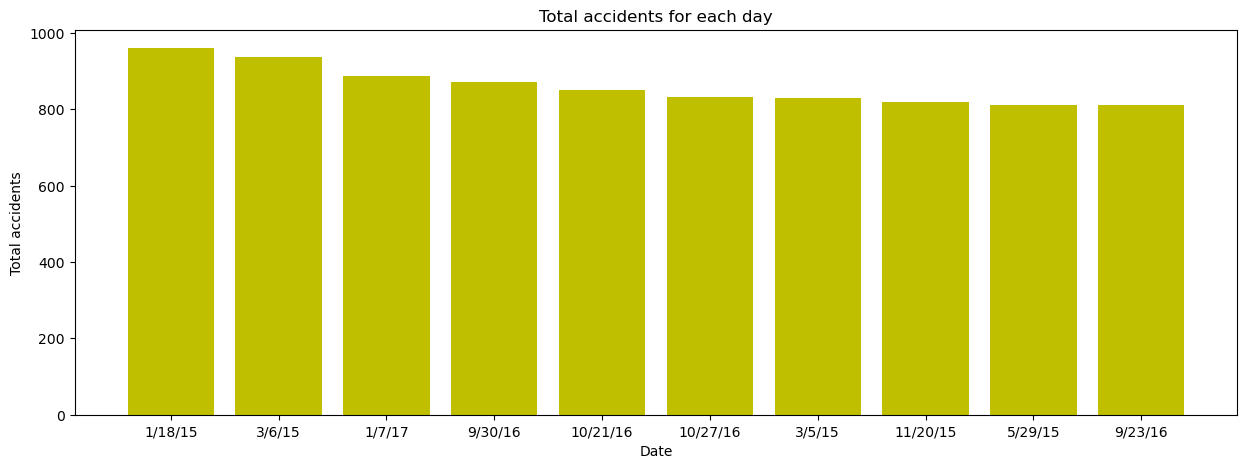

In [25]:
accidents_by_date_pipeline = [
    {
        '$project': {
            'Date': '$DATE',
            'PERSONS KILLED': 1,
            'PERSONS INJURED': 1
        }
    },
    {
        '$group': {
            '_id': '$Date',
            'Total Accidents': {'$sum': 1},
            'PERSONS KILLED': {'$sum': '$PERSONS KILLED'},
            'PERSONS INJURED': {'$sum': '$PERSONS INJURED'}
        }
    },
    {
        '$project': {
            '_id': 0,
            'Date': '$_id',
            'Total Accidents': 1,
            'PERSONS KILLED': 1,
            'PERSONS INJURED': 1,
            'Fatality%': {'$round': [{'$multiply': [{'$divide': ['$PERSONS KILLED', '$Total Accidents']}, 100]}, 3]},
            'Injury%': {'$round': [{'$multiply': [{'$divide': ['$PERSONS INJURED', '$Total Accidents']}, 100]}, 1]}
        }
    },
    {
        '$sort': {'Total Accidents': -1}
    }
]

accidents_by_date_db = mycol.aggregate(accidents_by_date_pipeline)

accidents_by_date_buffer = []
accidents_by_date = []
dates = []
total_accidents_for_mean = []


for accident in accidents_by_date_db:
    accidents_by_date_buffer.append(accident)
    total_accidents_for_mean.append(accident['Total Accidents'])

total_accidents_top_10_obj = accidents_by_date_buffer[0:10]

total_accidents_top_10 = []
dates_top_10 = []

for t_acc in total_accidents_top_10_obj:
    total_accidents_top_10.append(t_acc['Total Accidents'])
    dates_top_10.append(t_acc['Date'])


fig, axis = plt.subplots(figsize=(15, 5))


axis.bar(dates_top_10, total_accidents_top_10, color='y')

axis.set_title('Total accidents for each day')
axis.set_xlabel('Date')
axis.set_ylabel('Total accidents')

plt.show()

Lets start by looking at number of accidents per day, there are more than usual accidents on some days. Lets explore if there is any corelation with weather.

In [26]:
# with open('nyc_weather.csv', newline='') as csvfile:
#     csv_reader = csv.reader(csvfile, delimiter=',')
#     line_count = 0
#     for row in csv_reader:
#         if row[1] != 'datetime':
#             mydoc = mycol.update_many({'DATE': row[1]}, {"$set": { "CONDITION": row[29]}})

In [27]:
total_accidents_mean = mean(total_accidents_for_mean)
print('Mean of total accidents: ' + str(total_accidents_mean))

Mean of total accidents: 604.7240506329114


We got the historical weather data from [Visual Crossing](https://www.visualcrossing.com/) for the days where there are more accidents than the average number of accidents.

The weather conditions from this data is then read from the CSV file and inserted into the Mongo document. 

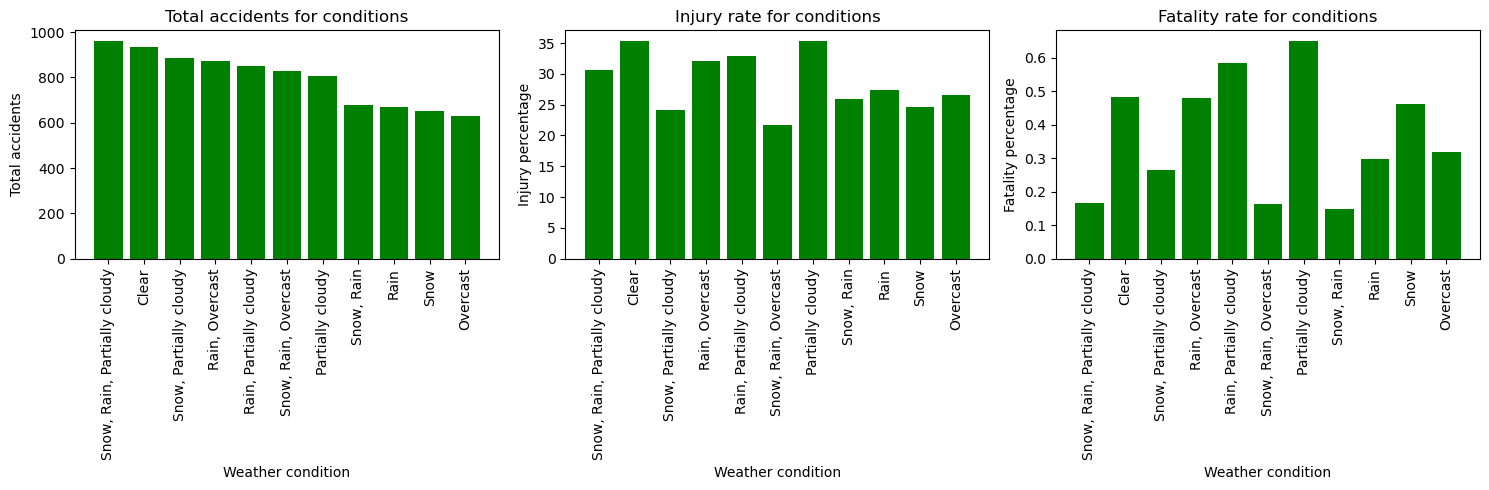

In [28]:

cnt = 0
for accident in accidents_by_date_buffer:
    if(accident['Total Accidents'] >= total_accidents_mean):
        #print(accident)
        accidents_by_date.append(accident)
        cnt += 1


total_accidents = []
for accident in accidents_by_date:
    dates.append(accident['Date'])
    total_accidents.append(accident['Total Accidents'])



pipeline_conditions  = [
    {
        "$match": {"DATE": {"$in": dates}}
    },
    {
        "$group": {
            "_id": "$DATE",
            "CONDITION": {"$first": "$CONDITION"},
            "DATE" : {"$first": "$DATE"}
        }
    },
    {
        "$project": {
            "_id": 0,
            "CONDITION": 1,
            "DATE": 1
        }
    }

]
accidents_by_date_top_10_conditions_db = mycol.aggregate(pipeline_conditions)
#print("*************************************************")
accidents_by_date_top_10_conditions = []

for rc in accidents_by_date_top_10_conditions_db:
    #print(rc)
    accidents_by_date_top_10_conditions.append(rc)



for top_acc in accidents_by_date:
    for top_acc_cond in accidents_by_date_top_10_conditions:
        if top_acc['Date'] == top_acc_cond['DATE']:
            top_acc['CONDITION'] = top_acc_cond['CONDITION']
            break
    


conditions = []
fatality_rate = []
injury_rate = []

for accident in accidents_by_date:
    conditions.append(accident['CONDITION'])
    fatality_rate.append(accident['Fatality%'])
    injury_rate.append(accident['Injury%'])


# print('accidents_by_date: ' + str(len(accidents_by_date)))
# print('total_accidents: ' + str(len(total_accidents)))
# print('conditions: ' + str(len(conditions)))
    
figure, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axs[0].bar(conditions, total_accidents, color='g')
axs[0].set_title('Total accidents for conditions')
axs[0].set_xlabel('Weather condition')
axs[0].set_ylabel('Total accidents')
axs[0].tick_params(axis='x', rotation=90)

axs[1].bar(conditions, injury_rate, color='g')
axs[1].set_title('Injury rate for conditions')
axs[1].set_xlabel('Weather condition')
axs[1].set_ylabel('Injury percentage')
axs[1].tick_params(axis='x', rotation=90)

axs[2].bar(conditions, fatality_rate, color='g')
axs[2].set_title('Fatality rate for conditions')
axs[2].set_xlabel('Weather condition')
axs[2].set_ylabel('Fatality percentage')
axs[2].tick_params(axis='x', rotation=90)

plt.subplots_adjust(hspace=1, bottom=0.2)
plt.tight_layout()
plt.show()

### Analysis 4: Investigate if date time and weather conditions play a role in injury and fatality rates.

- Upon analyzing the data, it was found that the highest number of accidents occurred during the weather conditions of 'Snow, Rain, Partially cloudy', followed closely by clear weather. Similar trends were observed in the injury rate, with 'partially cloudy' weather conditions having the highest injury rate, followed closely by clear weather. Hence, there appears to be no significant correlation between weather conditions and total accidents, and similarly no corelation between weather conditions and accident injury rate.

- In terms of accident fatality rate, the weather conditions of 'Partially cloudy' and 'Rain, Partially cloudy' showed the highest rate of fatality. However, clear weather conditions also followed closely behind, indicating that there may not be a significant correlation between weather conditions and accident fatality rate.

From this we can conlude that in New York city weather doesn't play a significate role for causing accidents, injury or fatality in accidents.